In [1]:
import pyodbc
from numpy import vectorize
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime
from os import getcwd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from UliPlot.XLSX import auto_adjust_xlsx_column_width

# SQL

In [2]:
# Get GMLA list and GMLA system date
cklist_confirm_query = """ 
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,[PROJECT_CATEGORY] as 'Segment'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      ,[status]
      /*,[kickOffMeetingDate]*/
      ,[baseOverDueDate] as 'actualCloseMeetingDate'
      ,[submitDate] as 'actualGMLASubmitDate'
      /*,[IsByPass]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_CONFIRM]

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names and segment */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/

  WHERE [IsByPass] = '0'
"""

# Get design review date which sync PM system
project_schedule_query = """ 
SELECT [ProjectSizeId] as 'projectSizeId'
      /*
      ,[PROJECT_NAME]
      ,[T_GT_ProjectSchedule].[TASK_ID]
      */
      ,[DESC_OF_TASK]
      /*
      ,[T_GT_TaskBaseInfo].[Note]
      ,[IsPM]
      */
      ,DATEADD(DAY,-21,[Current_Date]) as 'estCloseMeetingDate'
      /* Design review -21 days */
  FROM [PR_WEB2].[dbo].[T_GT_ProjectSchedule]

  LEFT JOIN [PR_WEB2].[dbo].[T_GT_TaskBaseInfo] 
  ON [T_GT_ProjectSchedule].[TASK_ID] = [T_GT_TaskBaseInfo].TASK_ID

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ProjectSizeId = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID
  
  WHERE DESC_OF_TASK
  IN ('Mechanical Design Review','Factory Prototype Design Review','Pilot Run Design Review')
"""

# Get GMLA D-17 screwVV questionnaire judgement
screwVV_query = """
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME]
      ,[no]
      /*,[questionnaire]*/
      ,[result]
      ,[reviewerFeedBack]
      ,[reviewerUserUpdated] as 'reviewer'
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST]
  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ([T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID = [T_GMLA_CKLIST].projectSizeId)
  WHERE no in ('2.D-17','3.D-17')
"""

In [3]:
connection_string = "DRIVER={SQL Server};SERVER=T1-PE-SUPPORT;DATABASE=PR_WEB2;UID=pimes2;PWD=LhZEv9JtGsZNX"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

cklist_confirm = pd.read_sql(cklist_confirm_query, engine)
project_schedule = pd.read_sql(project_schedule_query, engine, parse_dates='estCloseMeetingDate')
screwVV = pd.read_sql(screwVV_query, engine)

# cKlist_confirm

In [4]:
cklist_confirm.loc[cklist_confirm.actualCloseMeetingDate.str.startswith('0001-01', na=False),'actualCloseMeetingDate'] = None

In [5]:
cklist_confirm.actualCloseMeetingDate = pd.to_datetime(cklist_confirm.actualCloseMeetingDate, utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.actualGMLASubmitDate = pd.to_datetime(cklist_confirm.actualGMLASubmitDate,utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualCloseMeetingDate,actualGMLASubmitDate
0,766,GAD 13,Aviation,GMLA1,0,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,0,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,0,NaT,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,1,2021-02-05 00:00:00+08:00,2021-03-04 15:19:42.207827800+08:00
4,936,Edge 1040,Fitness,GMLA1,1,2021-02-05 00:00:00+08:00,2021-02-19 17:29:48.395736400+08:00


In [6]:
#Project id 1124 is aborted
cklist_confirm = cklist_confirm[cklist_confirm.projectSizeId != 1124]

Merge project_schedule

In [7]:
project_schedule.estCloseMeetingDate = project_schedule.estCloseMeetingDate.dt.tz_convert('Asia/Taipei')

In [8]:
project_schedule['Phase'] = project_schedule.DESC_OF_TASK.map(
    {'Mechanical Design Review':'GMLA1','Factory Prototype Design Review':'GMLA2','Pilot Run Design Review':'GMLA3'})
project_schedule.drop_duplicates(subset=['projectSizeId','Phase'], inplace=True)
# Some project have multi-design review date in PMsystem

In [9]:
overall = pd.merge(left=cklist_confirm, right=project_schedule, how='left', on=['projectSizeId','Phase'])
overall.drop('DESC_OF_TASK', axis=1, inplace=True)

In [10]:
def mergeCloseMeeting(actualCloseMeetingDate, estCloseMeetingDate):
    if actualCloseMeetingDate is pd.NaT:
        return estCloseMeetingDate
    else:
        return actualCloseMeetingDate
overall['mergedCloseMeetingDate'] = vectorize(mergeCloseMeeting)(overall.actualCloseMeetingDate, overall.estCloseMeetingDate)
#overall['mergedCloseMeetingDate'] = overall[['actualCloseMeetingDate','estCloseMeetingDate']].apply(lambda overall : mergeCloseMeeting(overall['actualCloseMeetingDate'], overall['estCloseMeetingDate']),axis=1)

In [11]:
overall['targetGMLASubmitDate'] = (overall.mergedCloseMeetingDate + BDay(8)).dt.date
overall.iloc[:,5:] = overall.iloc[:,5:].apply(lambda time: pd.to_datetime(time).dt.date)
overall.status = overall.status.map({1:'Complete',0:'Incomplete'})

In [12]:
overall.drop(['actualCloseMeetingDate','estCloseMeetingDate','mergedCloseMeetingDate'],axis=1, inplace=True)

In [13]:
overall.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualGMLASubmitDate,targetGMLASubmitDate
0,766,GAD 13,Aviation,GMLA1,Incomplete,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,Incomplete,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,Incomplete,NaT,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,Complete,2021-03-04,2021-02-17
4,936,Edge 1040,Fitness,GMLA1,Complete,2021-02-19,2021-02-17


# Screw V&V

In [14]:
screwVV['Phase'] = screwVV.no.apply(lambda no : 'GMLA2' if no.split('.')[0] == '2' else 'GMLA3' if no.split('.')[0] == '3' else None)
screwVV.result = screwVV.result.map({0:0,1:0,3:1})

In [15]:
screwVV_tailor = screwVV[['projectSizeId','Phase','result','reviewerFeedBack','reviewer']]
screwVV_tailor.head()

,projectSizeId,Phase,result,reviewerFeedBack,reviewer
0,833,GMLA2,1,confirmed.,evelyn.wang@garmin.com
1,833,GMLA3,0,None,None
2,856,GMLA3,0,None,None
3,961,GMLA2,1,Screw V&V is pass.,wendy.ni@garmin.com
4,961,GMLA3,0,None,None


In [16]:
overall_screwVV = pd.merge(left=overall, right=screwVV_tailor, left_on=['projectSizeId','Phase'], right_on=['projectSizeId','Phase'], how='inner')
overall_screwVV.rename(columns={'result':'screwVV_Judgement'},inplace=True)
overall_screwVV.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualGMLASubmitDate,targetGMLASubmitDate,screwVV_Judgement,reviewerFeedBack,reviewer
0,1012,Approach R50,Outdoor,GMLA2,Incomplete,NaT,NaT,0,None,None
1,1036,Approach S70s,Outdoor,GMLA2,Incomplete,NaT,2023-01-23,0,None,None
2,1089,Venu 3,Fitness,GMLA2,Incomplete,NaT,2022-12-30,0,None,None
3,1092,EPIX PRO (Gen 2) 42mm,Outdoor,GMLA2,Complete,2022-10-24,2022-10-28,1,(Confirmed by DPQE),aalto.lo@garmin.com
4,1092,EPIX PRO (Gen 2) 42mm,Outdoor,GMLA3,Incomplete,NaT,2023-01-11,0,None,None


Complete rate

In [17]:
complete = overall_screwVV.copy()


In [18]:
complete['screwVV_Judgement2'] = complete.screwVV_Judgement

In [19]:
complete.actualGMLASubmitDate = pd.to_datetime(complete.actualGMLASubmitDate)
complete = complete.set_index('actualGMLASubmitDate').resample(rule='BM').agg({'Project_Name':'count','screwVV_Judgement':'sum','screwVV_Judgement2':'count'})

In [20]:
complete['Complete_rate'] = 100*(complete['screwVV_Judgement2'] / complete['Project_Name']).round(2)
complete['Pass_rate'] = 100*(complete['screwVV_Judgement'] / complete['Project_Name']).round(2)

In [21]:
complete.index

DatetimeIndex(['2022-10-31', '2022-11-30', '2022-12-30'], dtype='datetime64[ns]', name='actualGMLASubmitDate', freq=None)

In [22]:
complete.index = complete.index.strftime('%y-%b')

In [23]:
complete

,Project_Name,screwVV_Judgement,screwVV_Judgement2,Complete_rate,Pass_rate
actualGMLASubmitDate,,,,,
22-Oct,5,5,5,100.0,100.0
22-Nov,13,12,13,100.0,92.0
22-Dec,7,7,7,100.0,100.0


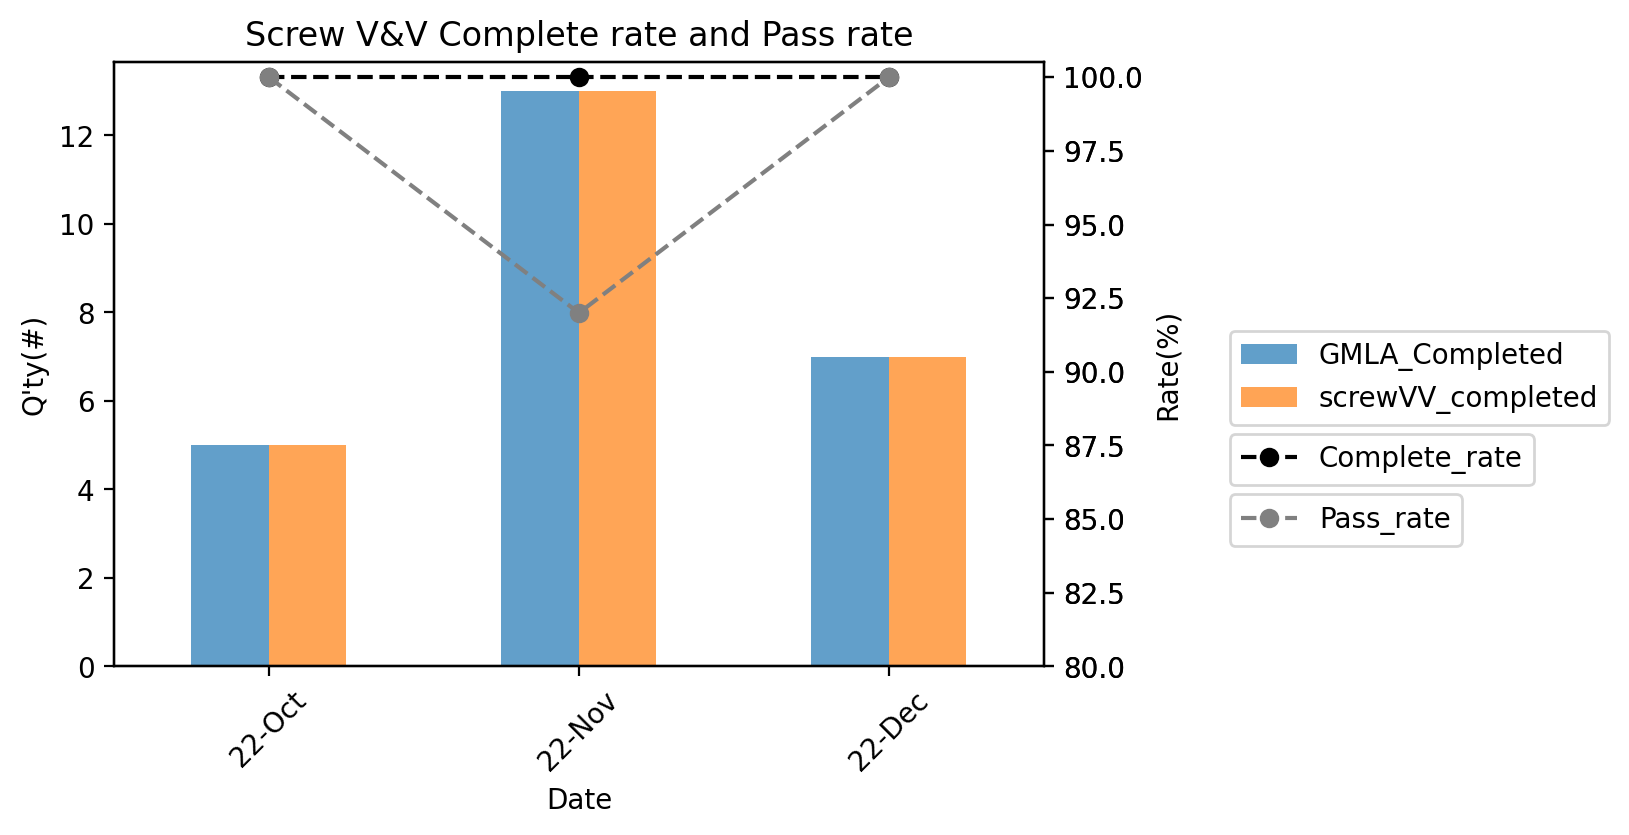

In [24]:
fig, ax1 = plt.subplots(dpi=200)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.sharey(ax2)

# Barplot for project count
plt.title('Screw V&V Complete rate and Pass rate')
complete[['Project_Name','screwVV_Judgement2']].plot.bar(ax=ax1, alpha=0.7)
ax1.set_ylabel("Q'ty(#)")
ax1.set_xlabel('Date')
ax1.legend(['GMLA_Completed','screwVV_completed'],loc=(1.2,0.4))

# Lineplot for complete rate
complete['Complete_rate'].plot(ax=ax2, marker='o', color='black', style='--')
ax2.set_ylim(top=100.5, bottom=80)
ax2.set_ylabel("Rate(%)")
ax2.legend(loc=(1.2,0.3))

complete['Pass_rate'].plot(ax=ax3, marker='o', color='grey', style='--')
ax3.legend(loc=(1.2,0.2))

# Rotate x-ticks
ax1.xaxis.set_tick_params(rotation=45)

# Excel writer

In [25]:
with pd.ExcelWriter('screwVV_tracking.xlsx',engine='openpyxl') as writer:
    overall_screwVV.to_excel(writer, sheet_name='overall_screwVV')
    auto_adjust_xlsx_column_width(overall_screwVV, writer, sheet_name="overall_screwVV", margin=6)